In [ ]:
%%capture
!pip install openai
!pip install sentence_transformers

import pandas as pd
import numpy as np
import openai
import matplotlib.pyplot as plt
import time
import pickle
import re

from sklearn.metrics.pairwise import cosine_similarity

from sentence_transformers import SentenceTransformer
emb_model_mini = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
# Load colab packages
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Translations

Motivation:

1. Translations of a service and given English texts are different.

2. Translations to not capture the meaning of the Ukrainian texts. There might be systematic evidence.

Procedure:

1. Out of three translation services: Google Translate, DeepL, and GPT 3.5, select the best performing one. This is done by finding the highest translation similarities comparing provided English translations by the channel and translations of each of the service, on a random sample.

2. Given the best service, translate all reamaining texts without translations.

In [ ]:
# Load data
df = pd.read_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_clean.csv')
df.shape

(2351, 21)

In [ ]:
# Functions to get embeddings and to compare them
def get_embedding(text: str):
  '''Takes text and return embedding'''
  em = emb_model_mini.encode(text)
  return em

def embedding_similarity(text1, text2):
  t1e = get_embedding(text1).reshape(1, -1) # Have to reshape as metric takes 1-D as input
  t2e = get_embedding(text2).reshape(1, -1)

  return cosine_similarity(t1e, t2e)[0][0]

## Translation validation

In [ ]:
# openai Key
openai.api_key = 'XXX'

In [ ]:
# Filter the data to messages wwith English equivalent
def validation_messages():
    df_val = df[df['message_split_en'].notnull() & df['message_split_en'].notna()].sample(200, random_state=42).reset_index(drop=True)

    # Check for non-null and non-NaN values
    assert df_val['message_split_en'].count() == df_val.shape[0]

    # Create list of messages
    return list(zip(df_val['message_split_uk'].to_list(), df_val['message_split_en'].to_list()))

validation_messages = validation_messages()

In [ ]:
# Structure: ("uk message", "en message")
validation_messages[19]

('Візит делегації Атлантичної ради в Україну – це черговий важливий сигнал підтримки нашої держави з боку Сполучених Штатів.\n\nДякую Президенту Байдену, усьому американському народу за потужну підтримку України від самого початку російської агресії. Цінуємо двопалатну та двопартійну підтримку Конгресу США.\n\nУкраїна відстоює демократичні цінності, які поділяють обидві наші держави й народи. Це боротьба за свободу, за майбутнє світу.\n\n',
 "\n\nThe visit of the Atlantic Council delegation to Ukraine is another important signal of the United States' support for our country.\n\nI thank President Biden and the entire American people for their strong support of Ukraine from the very beginning of Russian aggression. We appreciate the bicameral and bipartisan support of the U.S. Congress.\n\nUkraine defends democratic values shared by both our countries and peoples. This is a fight for freedom. For the future of the world.")

In [ ]:
# Function to translate a text from Ukrainian to English
def gpt_translation(text):
  translation = ''
  retry_count = 0  # counter for retry attempts
  while retry_count < 3:
        try:
          response = openai.ChatCompletion.create(
                                                  model = 'gpt-3.5-turbo',
                                                  temperature=0.25,
                                                  messages=[
                                                        {"role": "system", "content": "You are an advanced translation assistant capable of accurately translating Ukrainian to English with high proficiency."},
                                                        {"role": "user", "content": "Translate the following Ukrainian text to English: " + text},
                                                        ]
                                    )
          translation = response["choices"][0]["message"]["content"]
          break
          # Cacth exceptions
        except openai.error.APIError as e:
            print("APIError occurred:", e)
            retry_count += 1
            print("wait...")
            time.sleep(5)
        except openai.error.RateLimitError as e:
            print("RateLimitError occurred:", e)
            retry_count += 1
            print("wait...")
            time.sleep(5)
        except Exception as e:
            print("Another error occurred:", e)
            retry_count += 1
            print("wait...")
            time.sleep(5)
  if retry_count == 3:
      print("Maximum retry attempts reached for text:", text)

  return translation


In [ ]:
# Apply function to validation messages
trans_val_gpt = []
for index, m in enumerate(validation_messages):

  # Print status
  print('Message', index)
  if (index+1) % 50 == 0:
    print('zzz')
    #time.sleep(10)

  trans_val_gpt.append(gpt_translation(m[0]))

Message 0
Message 1
Message 2
Message 3
Message 4
Message 5
Message 6
Message 7
Message 8
Message 9
Message 10
Message 11
Message 12
Message 13
Message 14
Message 15
Message 16
Message 17
Message 18
Message 19
Message 20
Message 21
Message 22
Message 23
Message 24
Message 25
Message 26
Message 27
Message 28
Message 29
Message 30
Message 31
Message 32
Message 33
Message 34
Message 35
Message 36
Message 37
Message 38
Message 39
Message 40
Message 41
Message 42
Message 43
Message 44
Message 45
Message 46
Message 47
Message 48
Message 49
zzz
Message 50
Message 51
Message 52
Message 53
Message 54
Message 55
Message 56
Message 57
Message 58
Message 59
Message 60
Message 61
Message 62
Message 63
Message 64
Message 65
Message 66
Message 67
Message 68
Message 69
Message 70
Message 71
Message 72
Message 73
Message 74
Message 75
Message 76
Message 77
Message 78
Message 79
Message 80
Message 81
Message 82
Message 83
Message 84
Message 85
Message 86
Message 87
Message 88
Message 89
Message 90
Messa

In [ ]:
len(trans_val_gpt)

200

In [ ]:
# Save the final translation validation list
# with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/translation_validation_gpt3-5.pkl', 'wb') as f:
#     pickle.dump(trans_val_gpt, f)
with open('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/translation_validation_gpt3-5.pkl', 'rb') as f:
    trans_val_gpt = pickle.load(f)

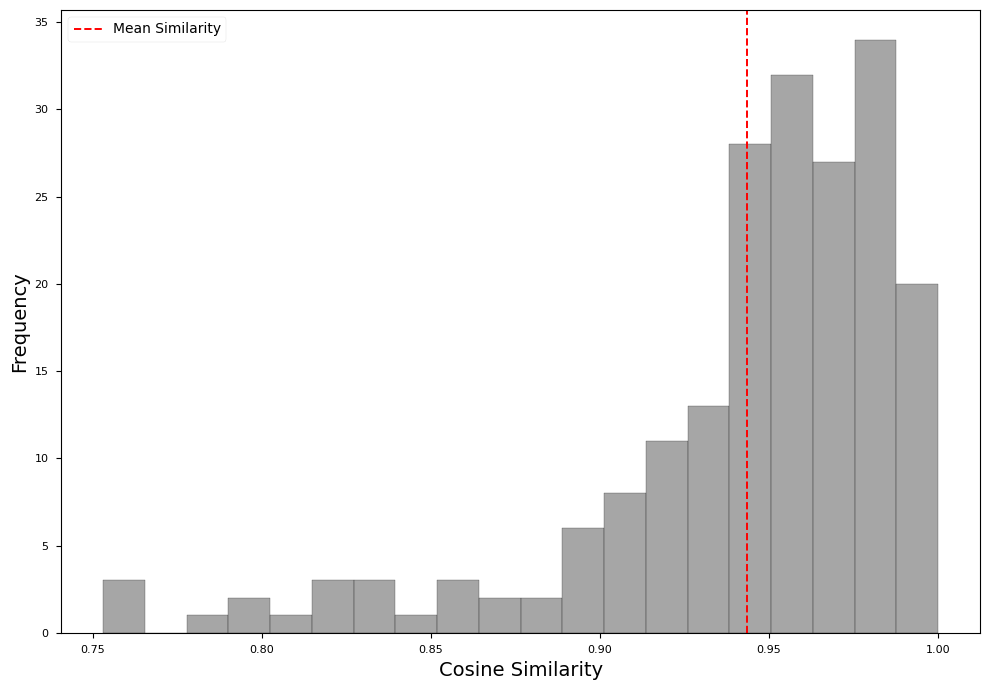

In [ ]:
# Get cosine similarities and plot them
def plot_cosine_similarity():
  trans_val_metrics = [embedding_similarity(trans_val_gpt[i],
                                          validation_messages[i][1]) for i in range(len(trans_val_gpt))]

  # Plotting the histogram
  plt.figure(figsize=(10,7))
  plt.hist(trans_val_metrics, bins=20, color='grey', edgecolor='black', alpha=0.7)  # Added edgecolor
  plt.axvline(x=np.mean(trans_val_metrics), color='r', linestyle='--', label='Mean Similarity')

  # Add labels, title and legend
  plt.xlabel('Cosine Similarity', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)
  #plt.title('Histogram of Cosine Similarities from GPT-3.5 Translations\nRandom Subset (n=200)', fontsize=16, pad=20)
  plt.legend(loc='upper left', fontsize=10)
  plt.tight_layout()
  plt.savefig('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Images/zelen_trans_validation.png', dpi=300)
  plt.show()

plot_cosine_similarity()



**Ideas**:

1. can also compare this to my previous histogram and approach. Arguing that it does a better job than Google Trans.

2. Argue why there are similarities lower than .85 or .9.

## Translation corpus

Idea: above validation shows that GPT shows strong results on translation, hence we can use GPT-3.5 for the rest of the corpus.

In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'date', 'message', 'views', 'forwards', 'reactions',
       'mime_type', '👍', '🙏', '❤', '😢', 'Total_emoijs', 'message_both',
       'message_split_en', 'message_split_uk', 'message_lan', 'message_score',
       'en_original', 'uk_trans', 'message_final'],
      dtype='object')

__Corpus__

There are two things we have to translate.

1. Messages that are in Ukrainian, this is the vast majority

2. Messages in both languages, without an English translation



In [ ]:
def translate_df():
  df_out = df.copy()
  for index, row in df_out.iterrows():

    # Print status
    print('Message', index+1)
    if index+1 % 50 == 0:
      print('zzz')
      time.sleep(10)

    # Select correct text
    if row['uk_trans'] == 1:
      if row['message_lan'] == 'uk' and row['message_both'] == 0 and pd.isna(row['message_final']):
        df_out['message_final'].iloc[index] = gpt_translation(row['message'])
        continue
      if row['message_both'] == 1 and pd.isna(row['message_split_en']) and pd.isna(row['message_final']):
        df_out['message_final'].iloc[index] = gpt_translation(row['message_split_uk'])

  return df_out

In [ ]:
# Apply function to entire corpus and save data
# Takes about 2-3 hours
df_trans = translate_df()

Message 1


<ipython-input-17-092183cd0a7c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out['message_final'].iloc[index] = gpt_translation(row['message'])


Message 2
Message 3
Message 4
Message 5
Message 6
Message 7
Message 8
Message 9
Message 10
Message 11
Message 12
Message 13
Message 14
Another error occurred: The server is overloaded or not ready yet.
Retrying after a brief wait...
Message 15
Message 16
Message 17
Message 18
Message 19
Message 20
Message 21


KeyboardInterrupt: ignored

In [ ]:
# Clean messages at the end
# Last cleaning, remove "Photo: ..."
# Remove noise from messages found during checking topics
def remove_noise(text: str) -> str:
  ''''''
  photo_pattern = 'Photo:.*?\.'
  return re.sub(photo_pattern, '', text)

df_trans['message_final'] = df_trans['message_final'].apply(remove_noise)

In [ ]:
# Save df
df_trans.to_csv('/content/drive/My Drive/01_LSE/2_Courses/ST/Dissertation/3_Ukraine_emotive_rethoric/Data/Inter/df_zelen_translation_gpt_3-5.csv', index=False)